<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Timeseries_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adolescent and Young Adult Group Whole Brain Cross Validation
Author: Stacey Rivet Beck

- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 

- Mount Google Drive, clone repository, upload config files to access AWS storage, Install libraries


##In Each Group Section we:

  1) Load local pickle file containing all masked, normalized Whole Brain  subject data in numpy matrix format. Option to load other mask data

  3) Run custom module **data_for_cv** to organize the data for the time series by detrending the data, applying z-score normalization and concantenating the time points for the training set and test set. 

  4) Call custom module **time_series_cv** with a list of parameters to perform cross validation. Saves/uploads metrics to AWS

  5) Download and explore the grid search metrics

  6) Plot the distributions for Parameters used C and Gamma and save to GDrive

### General Notes on each group:

- The data is separated into young adults and adolescents by group Id first where the subject ids of adolescents start with a '1' ie) '100XX-XXXXX' and the  young adult ids start with a '3' ie) '300XX-XXXXX' 

- We split the data 80-20 (holding out 20% of the data for unseen test data during model training) and from the 80% of that data, performed another split of 80-20 for train and validation sets for cross validation. All splits on subject Ids to ensure no data leakage. 


In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive', force_remount = True)

# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Mounted at /content/gdrive
Cloning into 'teambrainiac'...
remote: Enumerating objects: 2403, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 2403 (delta 165), reused 239 (delta 140), pack-reused 2125
Receiving objects: 100% (2403/2403), 159.54 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (1556/1556), done.
/content/teambrainiac/source/group_svm
access_data.py		    __init__.py
Adolescent_Group_SVM.ipynb  process.py
analysis.py		    Statistical_tests_decisions.ipynb
cross_validation.py	    Statistical_tests_Group.ipynb
data			    Timeseries_Cross_Validation.ipynb
Explore_data.ipynb	    train.py
Group_metrics.ipynb	    visualize.py
images			    Young_Adult_Group_SVM.ipynb


Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [ ]:
# Import libraries
!pip install boto3 nilearn

# Custom Modules
from process import *
from access_data import *
from cross_validation import time_series_cv

# Sklearn modules
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import TimeSeriesSplit, HalvingGridSearchCV
from sklearn.svm import SVC

# Plotting libraries
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data structure libs
import pickle
from collections import defaultdict
import nibabel as nib


## Adolescent Time Series Cross Validation
### Organize Data for Cross Validation



In [ ]:
%%time
# Get mat file 
mask_type =  'mask' 
label_type = 'rt_labels' 
from_mat = 'unnorm' #psc
data_type = "AD_detrend"
m_path_ind = 0 #get sub_mask data in mask_data key
l_path_ind = 0 #get data in data from rt_label key

#filename to save data in as a pickle, locally
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
subject_ids = data_path_dict['subject_ID']

# Check if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename in i.key:
    statement = True

if statement == False:
  print("Masking mat data...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind)
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)


Loading in masked data
CPU times: user 34.9 s, sys: 42.8 s, total: 1min 17s
Wall time: 1min 25s


In [ ]:
%%time 
# Split dataset into Adolescents adults
ad = subject_ids[:33]
print("Number of subjects for Adolescent ", len(ad))

#Function Calls
norm = "Detrend_Znorm" # 'RUNS', 'SUBJECTS' 
x_id = ad[:20] 
xt_id = ad[20:26] 
group_sub_ids = (x_id, xt_id)
runs_train = [1,2] # Grab run 2, 3 (0 indexing)
runs_test = [1,2] 


X, y = data_for_cv(data, group_sub_ids, runs_train, runs_test, norm)

Number of subjects for Adolescent  33
Normalizing Each based on Detrend_Znorm...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...

### Run the Adolescent Time Series Cross Validation

In [ ]:
max_train = 2000
test_size = None
splits = 5

directory = f'metrics/group_svm/{mask_type}/'
param_dict = {'C': [1, 5, 10, 1000],#[0.01, 0.1, 1,
              'gamma': [0.0001, 0.01, 'auto', 'scale'], 
              'max_iter': [1000],
              #'kernel': ['rbf']#, 'linear', 'sigmoid']}
              }
gd_srch = True
file_name = f'{directory}{data_type}_{mask_type}_grdsrchcv_1.pkl'

time_series_cv(X, y, max_train, test_size, splits, gd_srch, param_dict, file_name)

Uploading gridsearch results to cloud...
upload complete for metrics/group_svm/mask/AD_detrend_mask_grdsrchcv_1.pkl
Best parameters:  {'C': 10, 'gamma': 'scale', 'max_iter': 1000}
Best estimator:  SVC(C=10, class_weight='balanced', max_iter=1000, random_state=42)
Best score:  0.6607977991746905
CV results:  {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       2, 2]), 'n_resources': array([ 485,  485,  485,  485,  485,  485,  485,  485,  485,  485,  485,
        485,  485,  485,  485,  485, 1455, 1455, 1455, 1455, 1455, 1455,
       4365, 4365]), 'mean_fit_time': array([  2.92395129,   2.80068765,   2.85152426,   3.46837749,
         2.99618907,   2.97566271,   3.0449172 ,   3.01837502,
         2.8755106 ,   3.12138071,   2.78703718,   3.1787168 ,
         2.84339519,   2.98679547,   2.76983018,   3.04568515,
        24.69087429,  24.3491756 ,  24.6423945 ,  24.80755663,
        22.84905453,  23.97898855, 168.38443975, 163.06930108]), 'std_fit_time':

> Load saved gridsearch metrics from AWS to explore

In [3]:
data = access_load_data('metrics/group_svm/mask/AD_detrend_mask_grdsrchcv_1.pkl', False)
df = pd.DataFrame(data['grid_search'][0])
df.head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_max_iter,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,485,2.923951,1.349652,10.624213,3.207631,1,0.0001,1000,"{'C': 1, 'gamma': 0.0001, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
1,0,485,2.800688,1.305168,10.338471,3.221682,1,0.01,1000,"{'C': 1, 'gamma': 0.01, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
2,0,485,2.851524,1.295893,10.453241,3.205101,1,auto,1000,"{'C': 1, 'gamma': 'auto', 'max_iter': 1000}",...,0.5500,0.050000,16,1.0,1.0,1.0,0.990991,1.0,0.998198,0.003604
3,0,485,3.468377,1.820078,11.446483,4.202390,1,scale,1000,"{'C': 1, 'gamma': 'scale', 'max_iter': 1000}",...,0.5550,0.047170,15,1.0,1.0,1.0,0.990991,1.0,0.998198,0.003604
4,0,485,2.996189,1.341994,10.556773,3.234136,5,0.0001,1000,"{'C': 5, 'gamma': 0.0001, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
5,0,485,2.975663,1.396067,10.655935,3.257397,5,0.01,1000,"{'C': 5, 'gamma': 0.01, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
6,0,485,3.044917,1.418520,10.486166,3.121109,5,auto,1000,"{'C': 5, 'gamma': 'auto', 'max_iter': 1000}",...,0.5625,0.031623,9,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
7,0,485,3.018375,1.341454,10.421002,3.157601,5,scale,1000,"{'C': 5, 'gamma': 'scale', 'max_iter': 1000}",...,0.5625,0.031623,9,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
8,0,485,2.875511,1.313753,10.405101,3.208848,10,0.0001,1000,"{'C': 10, 'gamma': 0.0001, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
9,0,485,3.121381,1.551383,11.532144,4.607026,10,0.01,1000,"{'C': 10, 'gamma': 0.01, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000


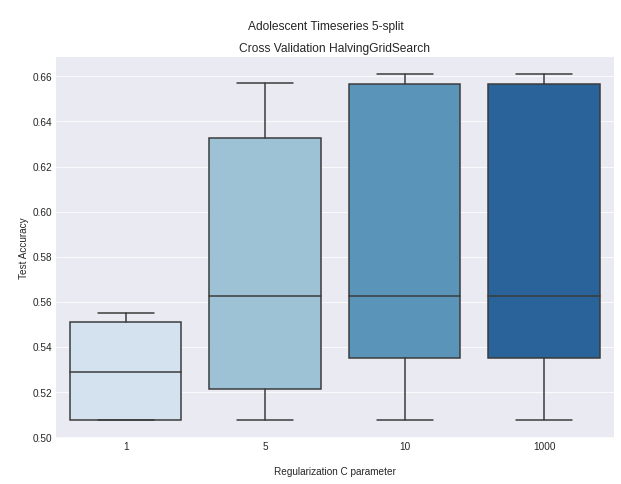

In [ ]:
# Adolescent Boxplot C param
plt.figure(figsize= (10, 7))
sns.boxplot(x = df['param_C'], 
            y = df['mean_test_score'], 
            palette = 'Blues'
            )
plt.style.use('seaborn-darkgrid')
plt.suptitle("\nAdolescent Timeseries 5-split")
plt.title('Cross Validation HalvingGridSearch')
plt.xlabel("\nRegularization C parameter")
plt.ylabel("\nTest Accuracy")
plt.savefig("/content/gdrive/MyDrive/ADOL/AD_detrend_Cboxplot.png", dpi = 200)
plt.show()

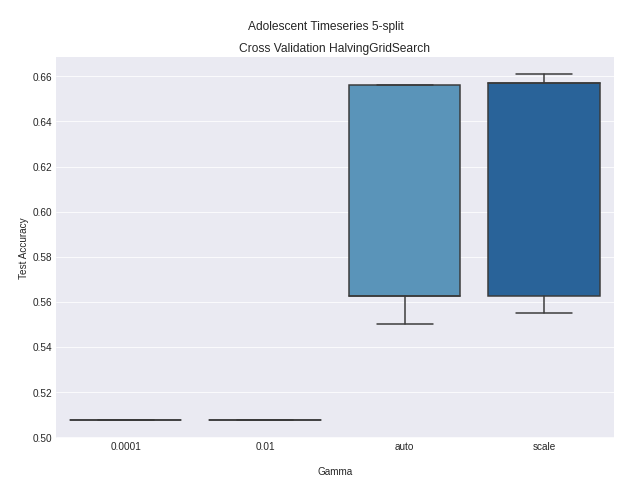

In [5]:
#Adolescent Gamma Parameter
plt.figure(figsize= (10, 7))
sns.boxplot(x = df['param_gamma'], 
            y = df['mean_test_score'], 
            palette = "Blues", 
            )
plt.style.use('seaborn-darkgrid')
plt.suptitle("\nAdolescent Timeseries 5-split")
plt.title('Cross Validation HalvingGridSearch')
plt.xlabel("\nGamma")
plt.ylabel("\nTest Accuracy")
plt.savefig("/content/gdrive/MyDrive/ADOL/AD_detrend_gammaboxplot.png", dpi = 200)
plt.show()

## Young Adult Time Series Cross Validation


In [ ]:
%%time
# Get mat file 
mask_type = 'mask'
label_type = 'rt_labels' 
from_mat = 'unnorm' #'psc' 'unnorm'
data_type = "YA_detrend"
m_path_ind = 0 #get sub_mask data in mask_data key
l_path_ind = 0 #get data in data from rt_label key


#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename2 = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']


# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename2 in i.key:
    statement = True

if statement == False:
  print("Masking mat data...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind)
  print(f"Saving data to local path {data_path}{filename2}")
  f = open(f"{data_path}{filename2}", "wb")
  pickle.dump(data, f)
  f.close()
elif statement == True:
  print("Loading in masked data")
  data = access_load_data(filename2, False)


Loading in masked data
CPU times: user 27.9 s, sys: 33.9 s, total: 1min 1s
Wall time: 1min 1s


In [ ]:
%%time 
# Split dataset into young adults
ya = subject_ids[33:]
print("Number of subjects for Young Adult ", len(ya))

#Function Calls
norm = "Detrend_Znorm" #"RUNS" , "SUBJECT"
x_id = ya[:12]
xt_id = ya[12:15]

group_sub_ids = (x_id, xt_id)
runs_train = [1,2] # Grab run 2, 3 (0 indexing)
runs_test = [1,2] 

X, y = data_for_cv(data, group_sub_ids, runs_train, runs_test, norm)

Number of subjects for Young Adult  19
Normalizing Each based on Detrend_Znorm...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Final X data shape to feed into Time Series Cross Validation (2520, 237979)
Final y data shape to feed into Time Series Cross Validation (2520,)
CPU times: user 11 s, sys: 30.8 s, total: 41.8 s
Wall time: 10.1 s


### Run the Time Series Cross Validation

In [ ]:
max_train = 1000
test_size = None
splits = 5
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
data_type = "YA_YA"

directory = f'metrics/group_svm/{mask_type}/'
param_dict = {'C': [0.1, 1, 5, 10, 1000],
              'gamma': [0.001, 0.01, 'auto', 'scale'],
              'max_iter': [1000],
              }
gd_srch = True
file_name2 = f'{directory}{data_type}_{mask_type}_grdsrchcv.pkl'

time_series_cv(X, y, max_train, test_size, splits, gd_srch, param_dict, file_name2)

Uploading gridsearch results to cloud...
upload complete for metrics/group_svm/mask/YA_YA_mask_grdsrchcv.pkl
Best parameters:  {'C': 1000, 'gamma': 'auto', 'max_iter': 1000}
Best estimator:  SVC(C=1000, class_weight='balanced', gamma='auto', max_iter=1000,
    random_state=42)
Best score:  0.7214285714285713
CV results:  {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2]), 'n_resources': array([ 280,  280,  280,  280,  280,  280,  280,  280,  280,  280,  280,
        280,  280,  280,  280,  280,  280,  280,  280,  280,  840,  840,
        840,  840,  840,  840,  840, 2520, 2520, 2520]), 'mean_fit_time': array([ 0.60020423,  0.59157782,  0.58671317,  0.65828686,  0.59239783,
        0.58528438,  0.58527875,  0.67405195,  0.58247256,  0.57878013,
        0.58269887,  0.69325771,  0.58782315,  0.57697067,  0.59684057,
        0.6730135 ,  0.5946578 ,  0.57829533,  0.58266516,  0.68252306,
        4.50768681,  4.57410164,  4.555

## Check gridsearch scores

In [6]:
grid_dict = access_load_data('metrics/group_svm/mask/YA_YA_mask_grdsrchcv.pkl', False)

In [7]:
import pandas as pd
grid_df = pd.DataFrame(grid_dict['grid_search'][0])
g = grid_df[['param_C',	'mean_test_score', 'param_gamma']]
g.head(10)

,param_C,mean_test_score,param_gamma
0,0.1,0.452174,0.001
1,0.1,0.452174,0.01
2,0.1,0.452174,auto
3,0.1,0.452174,scale
4,1,0.469565,0.001
5,1,0.469565,0.01
6,1,0.617391,auto
7,1,0.613043,scale
8,5,0.469565,0.001
9,5,0.469565,0.01


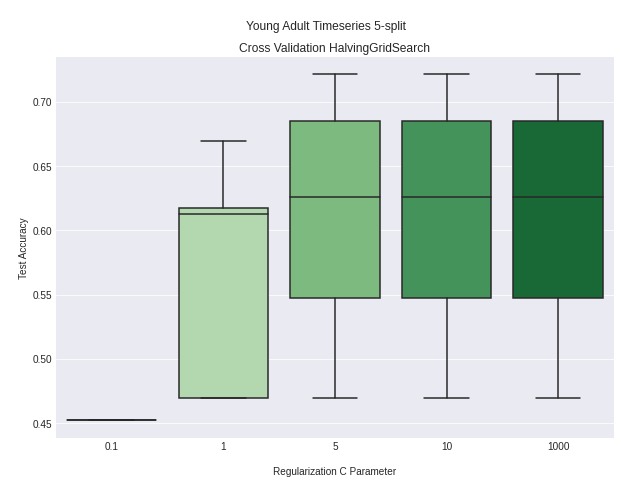

In [ ]:
## Young Adult C Param Boxplot
plt.figure(figsize= (10, 7))
sns.boxplot(x = g['param_C'], 
            y = g['mean_test_score'],
            palette = 'Greens'
            )
plt.style.use('seaborn-darkgrid')
plt.suptitle("\nYoung Adult Timeseries 5-split")
plt.title('Cross Validation HalvingGridSearch')
plt.xlabel("\nRegularization C Parameter")
plt.ylabel("\nTest Accuracy")
plt.savefig("/content/gdrive/MyDrive/YA/YA_detrend_Cboxplot.png", dpi = 200)
plt.show()

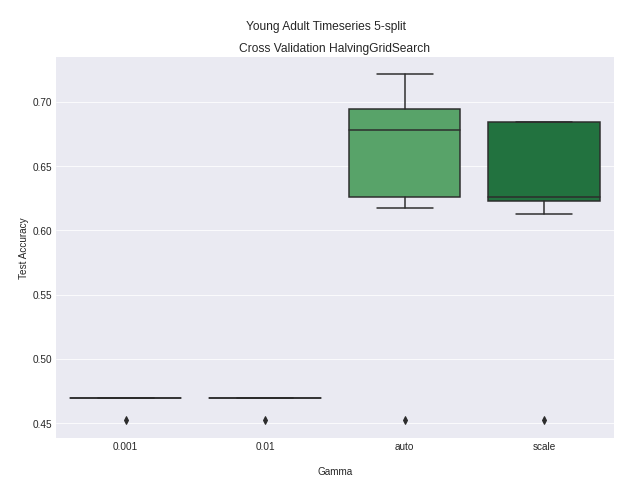

In [9]:
## Young Adult Gamma Barplot
plt.figure(figsize= (10, 7))
sns.boxplot(x = g['param_gamma'], 
            y = g['mean_test_score'],
            palette = 'Greens'
            )
plt.style.use('seaborn-darkgrid')
plt.suptitle("\nYoung Adult Timeseries 5-split")
plt.title('Cross Validation HalvingGridSearch')
plt.xlabel("\nGamma")
plt.ylabel("\nTest Accuracy")
plt.savefig("/content/gdrive/MyDrive/YA/YA_detrend_gammaboxplot.png", dpi = 200) # Save locally
plt.show()

Fin